[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import combinations, combinations_with_replacement

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


# [Thinking like Transformers](https://arxiv.org/abs/2106.06981)

Here we code our 'toy' GPT without any training in order to compute histograms. For the input sequence `<BOS>,a,a,b,a,b,c`, the output should be `0,3,3,2,3,2,1` as the letter `a` appears 3 times, the letter `b` 2 times and the letter `c` once. Each letter is replaced by its number of occurences (except `<BOS>` replaced by a `0`). 

## Self-Attention

First start by coding your Self-Attention layer (do not worry about initialization for the moment).

In [3]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.key_channels = config.key_channels
        self.Query = nn.Linear(self.n_channels, self.key_channels, bias=False)
        self.Key = nn.Linear(self.n_channels, self.key_channels, bias = False)
        self.Value = nn.Linear(self.n_channels, self.n_channels, bias = False)
        
    def _init_hist(self):
        self.Query.weight.data = 100*torch.eye(self.key_channels, self.n_channels)
        self.Key.weight.data = 100*torch.eye(self.key_channels,self.n_channels)
        self.Value.weight.data = torch.zeros(self.n_channels,self.n_channels)
        self.Value.weight.data[0,0] = 1.0
           
    def _init_id(self):
        self.Query.weight.data = 100*torch.eye(self.key_channels, self.n_channels)
        self.Key.weight.data = 100*torch.eye(self.key_channels,self.n_channels)
        self.Value.weight.data = torch.eye(self.key_channels,self.n_channels)        
        
    def forward(self, x): # x (bs, T, ic)
        Q = self.Query(x) # (bs, T, kc)
        K = self.Key(x)/math.sqrt(self.key_channels) # (bs, T, kc)
        V = self.Value(x) # (bs, T, oc)
        A = torch.einsum('bik,bjk->bij', Q, K) / np.sqrt(self.key_channels) # (bs, T, T)
        A = F.softmax(A, dim=-1)
        y = torch.einsum('bij,bjk->bik', A, V) # (bs, T, oc)
        return y, A

Check your implementation.

In [4]:
class toy_config:
    n_channels = 3
    key_channels = 3
    
sa_toy = SelfAttentionLayer(toy_config)

In [5]:
input = torch.randn(5,10,3)
y,A = sa_toy(input)

In [6]:
y.shape

torch.Size([5, 10, 3])

In [7]:
torch.sum(A, dim=-1)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]], grad_fn=<SumBackward1>)

## identity GPT

We first start with a simple example where we want to contruct the identity map. Clearly, in this case, we can just use the skip connections present in real transformer block. Instead, we will ignore these skip connections and use the self-attention layer. In this practical, we will ignore the layer norm.

To make our life simpler, we encode `<BOS>` with a `0`, letter `a` with a `1` and so on...

If we give as input the sequence `0,1,1,2,3,4,2,3,1`, we want to get the same sequence as output. This is clearly doable with a transformer block as follows:
- take one-hot encoding of each token 
- take Query and Key matrices as `100*Id`
- take Value matrix as `Id`
As a result, the output of the self-attention layer will be the same as the input.

Then take a Feed Forward Network which is simply the identity map as coded below:

In [8]:
class Block_id(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = SelfAttentionLayer(config)
        self.fake_mlp = (lambda x : x)
        self.attn._init_id()

    def forward(self, x):
        x, A = self.attn(x)
        x = self.fake_mlp(x)
        return x, A

In [9]:
nb_digits = 4
class config:
    n_channels=nb_digits+1
    key_channels=nb_digits+1

In [10]:
bid = Block_id(config)
one_sample = torch.tensor([[0.,0.,1.,0.,0.],[0.,1.,0.,0.,0.]]).unsqueeze(0)
bid(one_sample)

(tensor([[[0., 0., 1., 0., 0.],
          [0., 1., 0., 0., 0.]]], grad_fn=<ViewBackward0>),
 tensor([[[1., 0.],
          [0., 1.]]], grad_fn=<SoftmaxBackward0>))

Now to have really the identity map, we need to project back the one-hot encoding and this can be done with a linear layer (with good weights initialization).

In [11]:
class GPT_id(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.tok_emb = nn.Embedding(self.n_channels,self.n_channels)
        self.block = Block_id(config)
        self.head = nn.Linear(self.n_channels, 1, bias = False)
        self._init_weights()
        
    def _init_weights(self):
        self.tok_emb.weight.data = torch.eye(self.n_channels, self.n_channels)
        self.head.weight.data = torch.arange(self.n_channels, dtype=torch.float32)
        
    def forward(self, idx):
        x = self.tok_emb(idx)
        x, A = self.block(x)
        return self.head(x), A

In [12]:
gid = GPT_id(config)

In [13]:
one_sample = torch.tensor([0,1,1,2,3,4,2,3,1]).unsqueeze(0)
y, A = gid(one_sample)

In [14]:
y == one_sample

tensor([[True, True, True, True, True, True, True, True, True]])

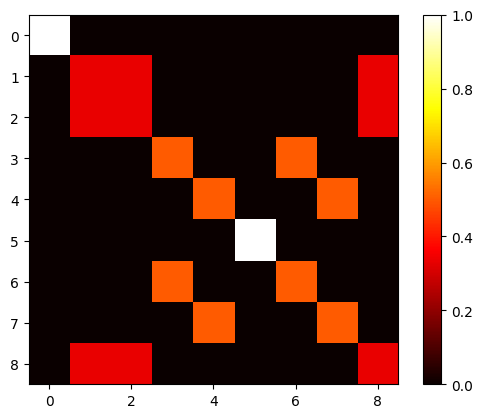

In [15]:
plt.imshow(A[0,:,:].cpu().data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

## histogram GPT

Now we need to adapt previous case to code our 'toy' transformer block and your 'toy' GPT to compute histograms:
- you will need to find a good initialization for the Quey, Key and Value matrices
- for the feed forward network, you can fake the mlp with any function you'd like.

In [16]:
class Block_hist(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = SelfAttentionLayer(config)
        self.fake_mlp = (lambda x : 1/x.sum(dim=-1, keepdim=True) - 1)
        self.attn._init_hist() # this need to be coded in your self attention layer

    def forward(self, x):
        x, A = self.attn(x)
        x = self.fake_mlp(x)
        return x, A

In [17]:
class GPT_hist(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.tok_emb = nn.Embedding(self.n_channels,self.n_channels)
        self.block = Block_hist(config)
        self._init_weights()
        
    def _init_weights(self):
        self.tok_emb.weight.data = torch.eye(self.n_channels,self.n_channels)
        self.tok_emb.weight.data[0,:] = torch.ones(self.n_channels)
        
        
    def forward(self, idx):
        x = self.tok_emb(idx)
        x, A = self.block(x)
        return x, A

Check your implementation by first choosing properly your configuration:

In [18]:
gh = GPT_hist(config)

In [19]:
one_sample = torch.tensor([0,1,1,2,3,4,2,3,1]).unsqueeze(0)
y, A = gh(one_sample)
y

tensor([[[0.],
         [3.],
         [3.],
         [2.],
         [2.],
         [1.],
         [2.],
         [2.],
         [3.]]], grad_fn=<SubBackward0>)

In [20]:
y.shape

torch.Size([1, 9, 1])

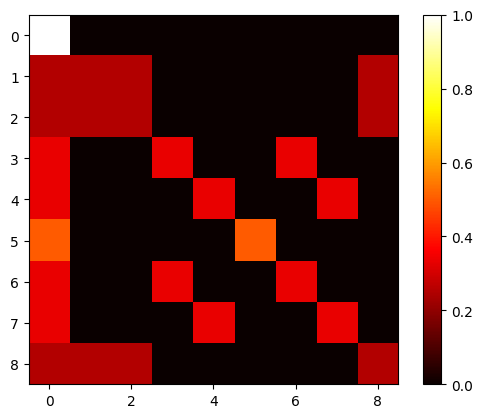

In [21]:
plt.imshow(A[0,:,:].cpu().data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Generating your dataset

Now, we will use a 'micro' GPT to learn the task of histograms. Before that, we will use our 'toy' GPT to generate the dataset. Since GPT is equivariant (a permutation of the input will permute the output), we can always take as input a sequence ordered. We can indeed compute all possible different inputs and this number is not too high. For a sequence of lenght `seq_train=s` with at most `nb_digits=n`, there are ${s+n-1 \choose n-1}$ possibilities. Now for each such sequence, we pass it through our toy GPT to get the label.

In [22]:
seq_train = 30
nb_digits = 4
comb = combinations_with_replacement(range(0,seq_train+1), nb_digits-1)

def make_seq(c, seq_train):
    c_l = [0] + list(c) + [seq_train]
    len_seq = len(c_l)-1
    return [c_l[i+1]-c_l[i] for i in range(len_seq)]

l_comb =  [make_seq(c,seq_train) for c in comb]

len(l_comb)

5456

In [23]:
math.comb(seq_train+nb_digits-1, nb_digits-1)

5456

In [24]:
def make_inputs(l_comb, nb_digits=nb_digits):
    inputs = []
    for t in l_comb:
        curr = [0]
        for (i,j) in enumerate(t):
            curr += [i+1 for _ in range(j)]
        inputs.append(torch.tensor(np.array(curr)))
    return inputs

def make_loader(len_seq,nb_digits):
    comb = combinations_with_replacement(range(0,len_seq+1), nb_digits-1)
    l_comb =  [make_seq(c,len_seq) for c in comb]
    inputs = make_inputs(l_comb)
    labels = [(gh(d.unsqueeze(0))[0].squeeze(0).squeeze(1)).type(torch.LongTensor) for d in inputs]
    dataset = list(zip(inputs,labels))
    len_in = len(dataset)
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
    return loader, len_in, inputs

In [25]:
train_loader, size_train, inputs_train = make_loader(seq_train,nb_digits)

In [26]:
size_train

5456

In [27]:
batch_in = next(iter(train_loader))

In [28]:
batch_in[0].shape

torch.Size([128, 31])

In [29]:
batch_in[1].shape

torch.Size([128, 31])

In [30]:
batch_in[0][0]

tensor([0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 4, 4, 4, 4, 4, 4], dtype=torch.int32)

In [31]:
batch_in[1][0]

tensor([ 0,  2,  2, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5])

# Coding 'micro' GPT

Now we need to code the 'micro' GPT used for learning. The game here is to reuse our `SelfAttentionLayer` above without any modification. The only part that is modified is the hard-coded `fake_mlp` which is now replaced by a real MLP.

In [32]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = SelfAttentionLayer(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_channels, 5 * config.n_channels),
            nn.ReLU(),
            nn.Linear(5 * config.n_channels, config.n_channels),
        )

    def forward(self, x, verbose=False): # x (bs, T,ic)
        x, A = self.attn(x)
        x = self.mlp(x)
        
        if verbose:
            return x, A
        else:
            return x

In [33]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_channels = config.n_channels
        self.nb_digits = config.nb_digits
        self.tok_emb = nn.Embedding(self.nb_digits+1,self.n_channels)
        self.block = Block(config)
        self.head = nn.Linear(config.n_channels, 1+config.max_hist)
        
    def forward(self, idx, targets=None, verbose=False):
        # shape of idx: (bs, len) 0=bos and 1...nb_digits
        # shape of targets: (bs, len)
        
        x = self.tok_emb(idx)
        if verbose:
            x, A = self.block(x,verbose=verbose)
        else:
            x = self.block(x) # x: (bs, len, in_channels)
        logits = self.head(x) # logits: (bs, len, max_hist)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1)) # your code here

        if verbose:
            return logits, loss, A
        else:
            return logits, loss

In [34]:
class config_gpt:
    nb_digits = nb_digits
    n_channels = 32 
    key_channels = 64 
    max_hist = seq_train+1

In [35]:
gptmini = GPT(config_gpt)

In [36]:
logits, _ = gptmini(batch_in[0])

In [37]:
logits.shape

torch.Size([128, 31, 32])

In [38]:
_,preds = torch.max(logits,-1)

In [39]:
preds.shape

torch.Size([128, 31])

In [40]:
batch_in[0].shape

torch.Size([128, 31])

In [41]:
torch.sum(preds == batch_in[1])

tensor(311)

In [42]:
def train_model(model, dataloader, size, epochs=1, optimizer=None):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        n_batch = 0
        for inputs,targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits, loss = model(inputs,targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(logits,-1)
           
            running_corrects += torch.true_divide(torch.sum(preds == targets.data),targets.shape[0]*targets.shape[1])
            running_loss +=  loss.data.item()
            n_batch += 1
        epoch_loss = running_loss / n_batch
        epoch_acc = running_corrects.data.item() / n_batch
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [43]:
len_train = (seq_train+1)*size_train

In [44]:
gptmini = GPT(config_gpt)
gptmini = gptmini.to(device)
lr = 0.01
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)
train_model(gptmini,train_loader,len_train,15,optimizer)

Loss: 2.8210 Acc: 0.1620


Loss: 1.9456 Acc: 0.3161
Loss: 1.6171 Acc: 0.3746
Loss: 1.4173 Acc: 0.4836
Loss: 1.3824 Acc: 0.4564
Loss: 1.1408 Acc: 0.5856
Loss: 1.2543 Acc: 0.5001
Loss: 0.9954 Acc: 0.6250
Loss: 0.9821 Acc: 0.6172
Loss: 1.0034 Acc: 0.6101
Loss: 0.9541 Acc: 0.6229
Loss: 1.0247 Acc: 0.5821
Loss: 0.8670 Acc: 0.6652
Loss: 0.8141 Acc: 0.6823
Loss: 0.7865 Acc: 0.6900


In [45]:
lr = 0.005
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)
train_model(gptmini,train_loader,len_train,15,optimizer)

Loss: 1.7793 Acc: 0.6355
Loss: 0.6131 Acc: 0.8660
Loss: 0.5659 Acc: 0.8751
Loss: 0.5386 Acc: 0.8887
Loss: 0.5152 Acc: 0.8907
Loss: 0.5134 Acc: 0.8541
Loss: 0.4778 Acc: 0.8796
Loss: 0.4388 Acc: 0.9016
Loss: 0.5243 Acc: 0.8072
Loss: 0.5479 Acc: 0.7942
Loss: 0.4198 Acc: 0.8804
Loss: 0.3861 Acc: 0.9002
Loss: 0.3863 Acc: 0.9000
Loss: 0.4100 Acc: 0.8588
Loss: 0.6673 Acc: 0.7157


In [46]:
lr = 0.001
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)
train_model(gptmini,train_loader,len_train,15,optimizer)

Loss: 0.3371 Acc: 0.9232
Loss: 0.2702 Acc: 0.9716
Loss: 0.2623 Acc: 0.9754
Loss: 0.2585 Acc: 0.9716
Loss: 0.2495 Acc: 0.9732
Loss: 0.2413 Acc: 0.9751
Loss: 0.2401 Acc: 0.9731
Loss: 0.2294 Acc: 0.9791
Loss: 0.2170 Acc: 0.9814
Loss: 0.2154 Acc: 0.9730
Loss: 0.2084 Acc: 0.9802
Loss: 0.2030 Acc: 0.9787
Loss: 0.1930 Acc: 0.9819
Loss: 0.1890 Acc: 0.9798
Loss: 0.1901 Acc: 0.9768


In [47]:
lr = 0.0001
optimizer = torch.optim.Adam(gptmini.parameters(),lr = lr)
train_model(gptmini,train_loader,len_train,15,optimizer)

Loss: 0.1701 Acc: 0.9852
Loss: 0.1667 Acc: 0.9856
Loss: 0.1656 Acc: 0.9875
Loss: 0.1644 Acc: 0.9879
Loss: 0.1633 Acc: 0.9868
Loss: 0.1625 Acc: 0.9873
Loss: 0.1607 Acc: 0.9868
Loss: 0.1598 Acc: 0.9884
Loss: 0.1589 Acc: 0.9869
Loss: 0.1576 Acc: 0.9883
Loss: 0.1567 Acc: 0.9876
Loss: 0.1557 Acc: 0.9877
Loss: 0.1550 Acc: 0.9874
Loss: 0.1543 Acc: 0.9869
Loss: 0.1530 Acc: 0.9871


In [48]:
one_batch = batch_in[0].to(device)
logits, loss, A = gptmini(one_batch,verbose=True)
A.shape

torch.Size([128, 31, 31])

input:tensor([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4,
        4, 4, 4, 4, 4, 4, 4], dtype=torch.int32)


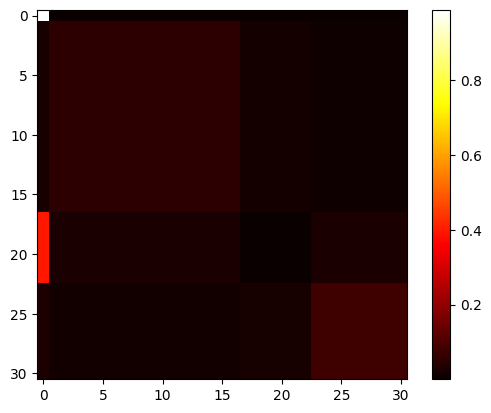

In [53]:
k = 120
print('input:' + str(batch_in[0][k]))
plt.imshow(A[k,:,:].cpu().data, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)